In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns; sns.set()
from pandas_datareader.data import DataReader

%matplotlib inline

# pra ignorar alguns avisos que podem aparecer
import warnings
warnings.filterwarnings("ignore")

Vamos escolher uma série temporal para usarmos

In [4]:
stock = 'AAPL'

df = DataReader(stock, data_source = 'yahoo', start = '2013')

In [5]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2013-01-02,79.285713,77.375717,79.142860,78.432854,140124866.0,74.945374
2013-01-03,78.524284,77.285713,78.278572,77.442268,88240950.0,73.998848
2013-01-04,76.947128,75.118370,76.735718,75.285713,148581860.0,71.938156
2013-01-07,75.614288,73.599998,74.578568,74.842857,121038176.0,71.514961
2013-01-08,75.984283,74.464287,75.552856,75.044289,114676751.0,71.707466


In [6]:
prices = df['Adj Close']

idx = pd.date_range(prices.index[0], prices.index[-1])

prices = prices.reindex(idx, method = 'ffill')

In [7]:
prices.head()

2013-01-02    74.945374
2013-01-03    73.998848
2013-01-04    71.938156
2013-01-05    71.938156
2013-01-06    71.938156
Freq: D, Name: Adj Close, dtype: float64

## Autocorrelação

Um dos conceitos mais importantes que permeará nossos modelos autorregressivos será o de **autocorrelação**, que nada mais é que a **correlação da série temporal com uma cópia dela mesma**, mas de uma forma **defasada** (ou seja, tomando cópias intervalados por períodos denominados **lags**):

<img src="https://i1.wp.com/www.business-science.io/assets/lag-explanation.PNG?w=584" width=400>

Para visualizar a autocorrelação, é muito comum que utilizemos os plots **ACF** e **PACF**:

### Função de Autocorrelação - Auto Correlation Function (ACF)

A função de autocorrelação, ACF, é calculada considerando **todos os instantes de tempo intermediários dentro do lag a partir do primeiro instante de tempo**.

É muito comum visualizá-la com auxílio da biblioteca statsmodels:

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

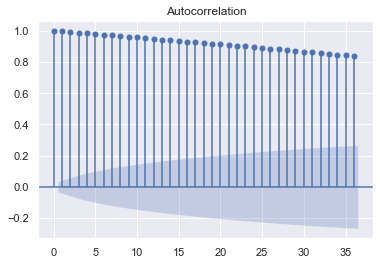

In [10]:
plot_acf(prices)
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

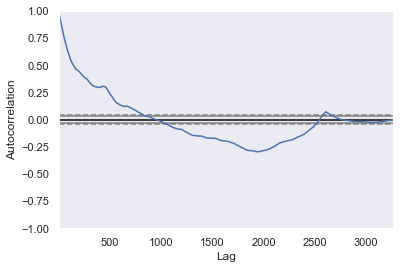

In [12]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(prices)

### Função de Autocorrelação Parcial - Partial Auto Correlation Function (PACF)

A função de autocorrelação parcial, PACF, é calculada considerando **apenas os instantes de tempo do lag, sem considerar os instantes intermediários**.

Também há um método do statsmodels para visualizarmos a PACF:

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf

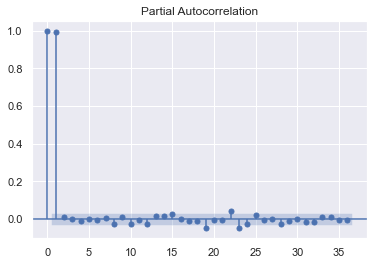

In [14]:
plot_pacf(prices)
plt.show()

### Estacionariedade

Uma série temporal é dita **estacionária** quando ela se desenvolve no tempo aleatoriamente ao redor de uma **média constante**, e com **variância constante**, refletindo um equilíbrio estável:

<img src="https://miro.medium.com/max/2580/1*tkx0_wwQ2JT7pSlTeg4yzg.png" width=550><br>

<img src="https://miro.medium.com/max/1147/1*xdblkZyg6YmmReAkZHUksw.png" width=650>


> -**Random walks** são exemplos de séries **não estacionárias**:

<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/01/Random-Walk-Line-Plot.png" width=450>

> **Séries sazonais** também não são estacionárias:

<img src="https://anomaly.io/wp-content/uploads/2015/12/multiplicative-model.png" width=450>

> - **White noise** é estacionário:

<img src="https://www.researchgate.net/publication/279249485/figure/fig10/AS:272660147994627@1442018653078/An-example-of-a-stationary-time-series-specifically-a-series-of-uncorrelated-white.png" width=500>

Para avaliarmos se uma série temporal é ou não estacionária, fazemos o [teste de Dickey-Fuller](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test).

In [22]:
prices =  prices.loc[:'2019-11']

<AxesSubplot:ylabel='Adj Close'>

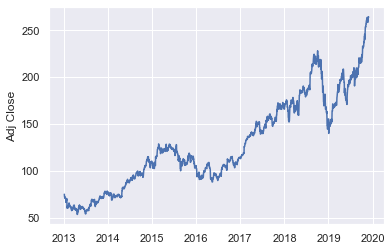

In [23]:
sns.lineplot(x = prices.index, y = prices)

In [24]:
from statsmodels.tsa.stattools import adfuller

adfuller(prices)

(0.6635963802616487,
 0.9890826581502908,
 13,
 2510,
 {'1%': -3.4329579682301254,
  '5%': -2.8626921885291017,
  '10%': -2.5673833542324727},
 9937.456625668972)

Para **tornarmos uma série não-estacionária estacionária**, há um procedimento muito simples que modemos tentar fazer:
tomar as variações entre diferentes instantes de tempo, o que fazemos com o método `diff()`, que é bem similar ao `pct_change()`, exceto pelo fato de que não há a divisão pelo instante anterior:

> `diff()`: $P_t - P_{t-1}$

> `pct_change()`: $\frac{P_t - P_{t-1}}{P_{t-1}}$

In [25]:
difs = prices.diff().dropna()

difs

2013-01-03   -0.946526
2013-01-04   -2.060692
2013-01-05    0.000000
2013-01-06    0.000000
2013-01-07   -0.423195
                ...   
2019-11-26   -2.053223
2019-11-27    3.504303
2019-11-28    0.000000
2019-11-29   -0.582428
2019-11-30    0.000000
Freq: D, Name: Adj Close, Length: 2523, dtype: float64

<AxesSubplot:ylabel='Adj Close'>

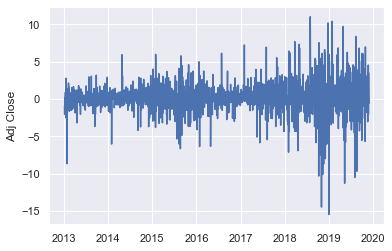

In [26]:
sns.lineplot(x = difs.index, y = difs)

In [27]:
adfuller(difs)

(-13.224613016409505,
 9.859472778662617e-25,
 12,
 2510,
 {'1%': -3.4329579682301254,
  '5%': -2.8626921885291017,
  '10%': -2.5673833542324727},
 9932.834876934747)

Agora que conhecemos o importanto processo de estacionaridade, vamos introduzir dois procedimentos que são utilizados **para modelar processos estacionários**.

## Modelos AR

O primeiro modelo que vamos tratar é o **Modelo AutoRegressivo** (daí o **AR**). 

O objetivo deste (e dos demais modelos que veremos) é **capturar o padrão por trás da série e prever o comportamento futuro a partir do passado**.

Este modelo estabelece uma relação muito precisa entre diferentes instantes de tempo, expressa a seguir como o **modelo autorregressivo de ordem $p$ - $\text{AR}(p)$:**


$$R_t = \mu + \sum_{i=1}^p \phi_i R_{t-i} + \epsilon_t \ , $$

Ou seja,

$$R_t = \mu + \phi_1 R_{t-1} + \phi_2 R_{t-2} + \cdots + \phi_p R_{t-p} + \epsilon_t \ , $$

Onde:

- $R_t$ é o instante atual;
- $p$ é o número de lags considerado no modelo (também chamado de **ordem** do modelo);
- $R_{t-p}$ é o instante de tempo passados p lags;
- $\phi_p$ é o respectivo coeficiente da PACF.

Um bom modelo será um que utiliza um número $p$ de lags da PACF fora do cone de confiança (ou seja, estatisticamente significantes).


## Modelos MA

Vamos tratar agora do **Modelo de Média Móvel** (**Moving Average**, daí o **MA**). 

Diferente dos modelos AR, os modelos MA estabelecem uma relação não entre os valores de diferentes instantes de tempo, mas sim entre **os ruídos de diferentes instantes de tempo**. Esta rellação é xpressa a seguir como o **modelo de média móvel de ordem $q$ - $\text{MA}(q)$:**

$$R_t = \mu + \sum_{i=1}^q \theta_i \epsilon_{t-i} + \epsilon_t \ , $$

Ou seja,

$$R_t = \mu + \theta_1 \epsilon_{t-1} + \theta_2\epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q} + \epsilon_t \ , $$

Onde:

- $R_t$ é o instante atual;
- $q$ é o número de lags considerado no modelo (também chamado de **ordem** do modelo);
- $\epsilon_{t-q}$ é o ruído entre o instante atual e o instante após q lags;
- $\theta_q$ é o respectivo coeficiente da ACF.

Um bom modelo será um que utiliza um número $q$ de lags da ACF fora do cone de confiança (ou seja, estatisticamente significantes).


## Modelos ARIMA

Por fim, chegamos ao modelo mais complexo que aprenderemos, o **AutoRegressive Integrated Moving Average**.

Estes modelos se diferenciam do ARMA ao incorporar o procedimento de **diferenciação** da série temporal **original e não estacionária**. Este procedimento faz com que a série se torne estacionária para que o forecasting seja feito. Então, como passo final, a diferenciação é revertida com a **integração**, o que faz com que as predições sejam feitas em termos dos valores originais.

Assim, poderemos com o ARIMA utilizar diretamente as séries de preços!

Os modelos $\text{ARIMA}(p, d, q)$ têm as seguintes componentes:

- p: número de defasagens autoregressivas;
- d: ordem da difereenciação das defasagens;
- q: número de defasagens das médias móveis.

Vamos à construção do modelo!

In [28]:
from statsmodels.tsa.arima_model import ARIMA

In [29]:
model = ARIMA(prices, order=(1, 1, 1)).fit()

In [30]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Adj Close   No. Observations:                 2523
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5031.156
Method:                       css-mle   S.D. of innovations              1.777
Date:                Fri, 10 Dec 2021   AIC                          10070.312
Time:                        21:52:52   BIC                          10093.645
Sample:                    01-03-2013   HQIC                         10078.779
                         - 11-30-2019                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0749      0.034      2.197      0.028       0.008       0.142
ar.L1.D.Adj Close     0.2242      0.318      0.705      0.481      -0.399       0.847
ma.L1.D.Adj Close    -0.2527      0.315     -0.802      0.423      -0.870       0.365
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.4606           +0.0000j            4.4606            0.0000
MA.1            3.9578           +0.0000j            3.9578            0.0000
-----------------------------------------------------------------------------
"""

In [31]:
price_test = prices.iloc[-60:]

In [51]:
preds = model.predict(start = price_test.index[0],
                    end = price_test.index[-1],
                    typ = 'levels')

In [46]:
price_test_diff = price_test.diff().dropna()

In [47]:
price_test_diff = price_test_diff * 0.033

<AxesSubplot:ylabel='Adj Close'>

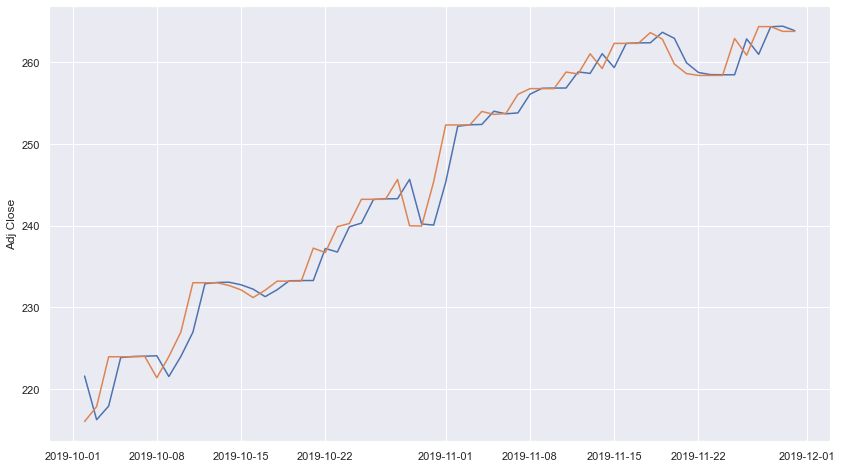

In [52]:
plt.figure(figsize=(14,8))

sns.lineplot(x = preds.index, y = preds)
sns.lineplot(x = price_test.index, y = price_test)